In [1]:
import time
import numpy as np
import matplotlib.pyplot as pl
import sys
from decimal import *
from numpy.fft import fft, fftfreq, ifft, fft2, fftshift, fftn
start = time.time()



def load_binary_data(filename, dtype=np.float32): 
         """ 
         We assume that the data was written with write_binary_data() (little endian). 
         """ 
         f = open(filename, "rb") 
         data = f.read() 
         f.close() 
         _data = np.fromstring(data, dtype) 
         if sys.byteorder == 'big':
           _data = _data.byteswap()
         return _data 
        
        

def ps_k(box_name , k_end_of_first_bin, k_growth_factor, mode = 'whatever'):

    L_box = 300
    DIM = 200
    k_growth_factor = k_growth_factor
    #k_end_of_first_bin = float(k_end_of_first_bin)
    #print mode

    
    def create_k_boundaries(k_end_of_first_bin, k_growth_factor):
        
        if mode == 'power':
            #make the bins for k with growth factor 
            k_end_of_first_bin = float(k_end_of_first_bin)
            numbins = 0
            k_floor = 0
            k_ceil = k_end_of_first_bin
            k_range = []
            while(k_ceil< kmax):
                numbins += 1 
                k_range.append(k_ceil)
                k_floor = k_ceil
                k_ceil = k_ceil*k_growth_factor
            print ('num of power bins are' , numbins)
            
        if mode == 'linear':
        
            #make the bins for k with linear addiation
            k_end_of_first_bin = float(k_end_of_first_bin)
            numbins = 0
            k_floor = 0
            k_ceil = k_end_of_first_bin
            k_range = []
            while(k_ceil< kmax):
                numbins += 1 
                k_range.append(k_ceil)
                #update floor and ceiling
                k_floor = k_ceil
                k_ceil = k_ceil+k_end_of_first_bin
            print ('num of linear bins are' , numbins)
            
        return numbins, k_range
    
    def populate_bins(i,j,l):
        
        if mode == 'power':
            k_floor = 0
            k_ceil = k_end_of_first_bin
            binn = 0
            while(k_ceil < kmax):
                if ((k >= k_floor) and (k < k_ceil)):
                    power_spectrum[binn] += ps[i][j][l]
                    bin_counter[binn] += 1
                k_floor = k_ceil
                k_ceil = k_ceil*k_growth_factor
                binn += 1
                
        if mode == 'linear':
            k_floor = 0
            k_ceil = k_end_of_first_bin
            binn = 0
            while(k_ceil < kmax):
                if ((k >= k_floor) and (k < k_ceil)):
                    power_spectrum[binn] += ps[i][j][l]
                    bin_counter[binn] += 1
                k_floor = k_ceil
                k_ceil = k_ceil+k_end_of_first_bin
                binn += 1


    arr = load_binary_data(box_name)
    arr.shape = (DIM, DIM, DIM)
    data = arr.reshape((DIM, DIM, DIM), order='F')
    #print data[0][199][100]
    #print(data.shape)
    #print data.shape
    pl.imshow(data[0])

    #find the average of the data
    avg = np.full((DIM, DIM, DIM ), np.mean(data))
    data = np.subtract(data,avg)


    #sample rate determines maximum k 
    #fsampling
    delta = (float(L_box/DIM))
    fsample = (1/delta)

    #k axes for graphing purposes
    k_x = fftshift(fftfreq(DIM, d = delta))
    #symmetry in k 
    k_y = k_x
    k_z = k_x

    #fourier transform
    raw_transform = fftshift(fftn(data))
    fourier_transform = np.abs(raw_transform/np.sqrt(DIM**3))

    #power in the transform
    ps = np.abs(raw_transform/(np.sqrt(DIM**3)))**2     

    #make a grid in prepartation for plots
    k_X, k_Y, k_Z = np.meshgrid(k_x, k_y, k_z)

    #find kmax
    kmax = np.zeros(3)
    kmax = (np.amax(k_x), np.amax(k_y), np.amax(k_z))
    kmax = np.sqrt(kmax[0]**2+kmax[1]**2+kmax[2]**2)

    
    
    #determine number of bins
    num_bins = create_k_boundaries(k_end_of_first_bin, k_growth_factor)[0]
    k_range = create_k_boundaries(k_end_of_first_bin, k_growth_factor)[1]
    
    #initialize arrays
    power_spectrum = np.zeros(num_bins)
    bin_counter = np.zeros(num_bins)
    
    
    
    #cycle through all magnitude of k values
    for i in range(DIM):
        for j in range(DIM):
            for l in range(DIM):
                k = np.sqrt(k_x[i]**2+k_y[j]**2+k_z[l]**2)
                #determine which bin this k falls into
                populate_bins(i,j,l)
                
                
                #k_floor = 0
                #k_ceil = k_end_of_first_bin
                #binn = 0
                #while(k_ceil < kmax):
                    #if ((k >= k_floor) and (k < k_ceil)):
                        #power_spectrum[binn] += ps[i][j][l]
                        #bin_counter[binn] += 1
                    #k_floor = k_ceil
                    #k_ceil = k_ceil*k_growth_factor
                    #binn += 1

    #average out over shells of constant k
    for i in range(num_bins):
            #print bin_counter[i]
            if bin_counter[i] == 0:
                power_spectrum[i] = 0 
            else:
                power_spectrum[i] = ((k_range[i])**3)*power_spectrum[i]/(bin_counter[i]*L_box**3)
                #print power_spectrum[i]
                
    
    #check to see if there are a string of zeros and then remove them
    #i = 0
    #while power_spectrum[i] < 0.000005*np.amax(power_spectrum):
    #    print i
     #   i += 1
    #power_spectrum = power_spectrum[i:]
    #k_range = k_range[i:]
    
    global k_bins
    k_bins = k_range         

    #log plot the power spectrum vs k
    pl.figure(2)
    pl.semilogx(k_range, power_spectrum/(2*np.pi**2), linewidth = 2)
    pl.xlabel(r'$k$', fontsize = 17)
    pl.ylabel(r'$k^3P(k)/2\pi^2$',fontsize = 17)
    
    
    return power_spectrum
    


#ps_T2 = ps_k('delta_T_v3_z008.00_nf0.527502_useTs0_200_300Mpc2', 0.00008, 1.5, mode = 'power')

end = time.time()
print ('Runtime(s):', (end - start))

('Runtime(s):', 0.0015571117401123047)


In [2]:
#slope comparison
def check_shape(ps_dx_i, ps_dx_j):
    
    #check for change by comparing unit tangents
    num_slopes = len(ps_dx_i)-1
    print ('We will use ' , num_slopes, 'for our comparison')
    dpdk_i = np.zeros(num_slopes)
    dpdk_j = np.zeros(num_slopes)
    for i in range(num_slopes):
        dpdk_i[i] =(ps_dx_i[i+1]-ps_dx_i[i])/(k_bins[i+1]-k_bins[i])
        dpdk_i[i] = dpdk_i[i]/(np.sqrt(1+dpdk_i[i]**2))


    dpxHdk = np.zeros((num_slopes))
    for i in range(num_slopes):
        dpdk_j[i] =(ps_dx_j[i+1]-ps_dx_j[i])/(k_bins[i+1]-k_bins[i])
        dpdk_j[i] = dpdk_j[i]/(np.sqrt(1+dpdk_j[i]**2))


    d2pdk_i = np.zeros(num_slopes-1)
    for i in range(num_slopes -1):
        d2pdk_i[i] = (dpdk_i[i+1]-dpdk_i[i])/(k_bins[i+1]-k_bins[i])

    diff_in_slopes = np.zeros((num_slopes))
    diff_in_slopes = np.subtract(dpdk_i,dpdk_j)
    
    return diff_in_slopes

NameError: name 'k_bins' is not defined

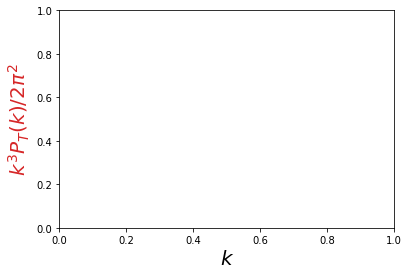

In [4]:
#import seaborn as sns
#def compare_plots(ps1, ps2):

#sns.set()
fig, ax1 = pl.subplots()

color = 'tab:red'
ax1.set_xlabel(r'$k$', fontsize = '20')
ax1.set_ylabel(r'$k^3P_T(k)/2\pi^2$', fontsize ='20', color=color)
ax1.plot(k_bins, ps_dx_cross, color=color)
ax1.tick_params(axis='y', labelcolor=color)
pl.xlim(10**-8.5,0.85)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'$k^3P_{xH}(k)/2\pi^2$', fontsize = '20', color=color)  # we already handled the x-label with ax1
ax2.plot(k_bins, ps_dx_10, color=color)
ax2.tick_params(axis='y', labelcolor=color)
pl.xlim(10**-8.5,10**0)

fig.tight_layout()  
pl.show()


#error is proportional 1/np.sqrt(N_points)

